# Exploring LeafSnap Dataset

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models




### Create a DataFrame

In [9]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
df.head()

# Number of images per species
species_counts = df['species'].value_counts()
print(species_counts.head(10))


species
Maclura pomifera            448
Ulmus rubra                 317
Prunus virginiana           303
Acer rubrum                 297
Broussonettia papyrifera    294
Prunus sargentii            288
Ptelea trifoliata           270
Ulmus pumila                265
Abies concolor              251
Asimina triloba             249
Name: count, dtype: int64


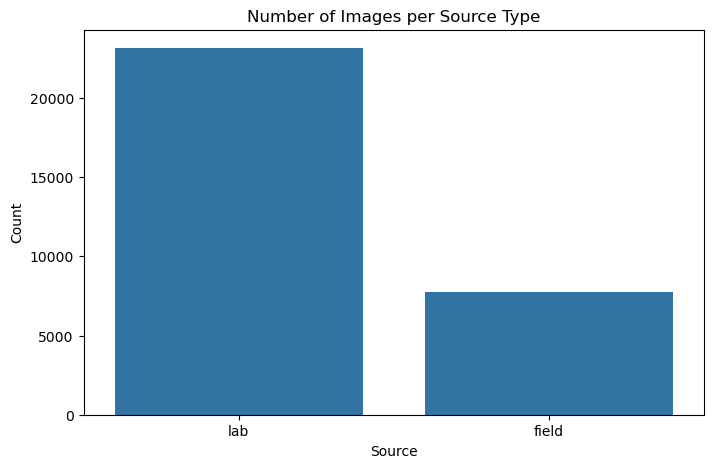

In [10]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='source')
plt.title('Number of Images per Source Type')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

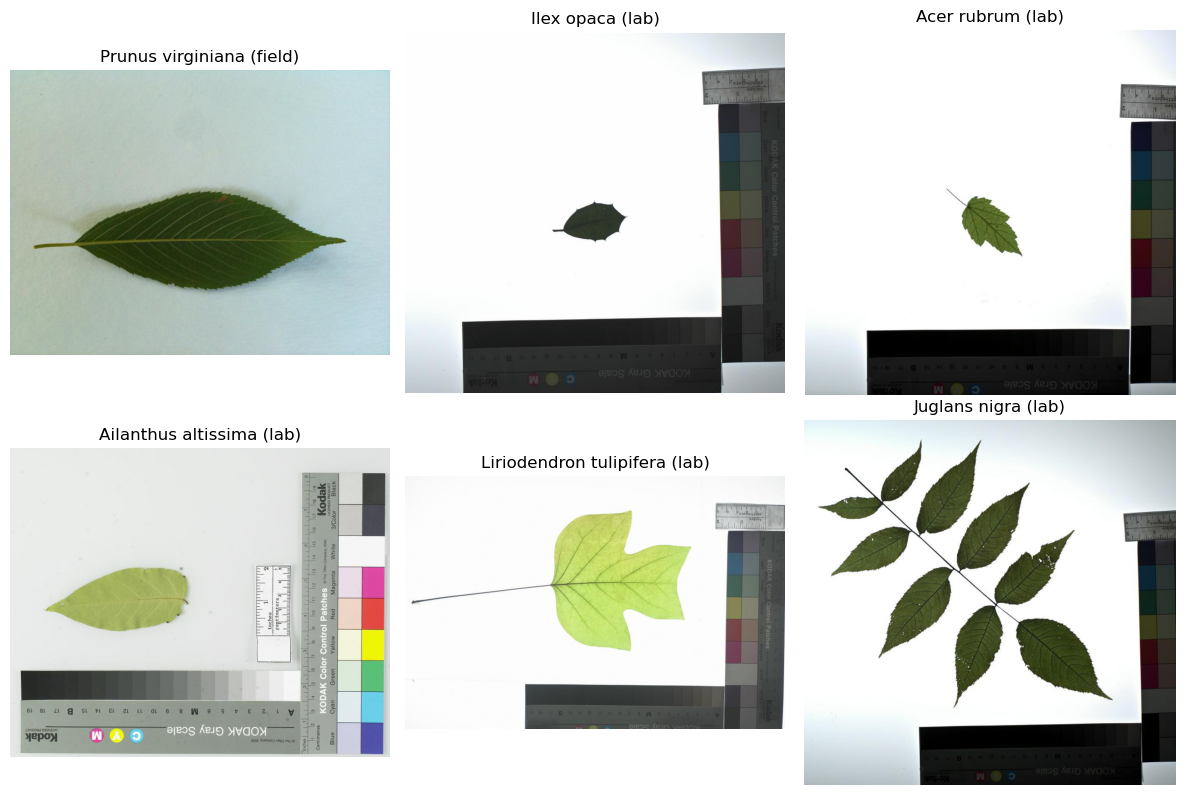

In [11]:

sample = df.sample(6)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row['image_path'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row['species']} ({row['source']})")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Preprocessing

In [12]:
IMG_SIZE = (128, 128)

image_paths = df['segmented_path'].tolist()
labels = df['species'].tolist()

# Encode :D
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels)

# Image loading 
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = test_ds.map(lambda x, y: (preprocess_image(x), y)).batch(32).prefetch(tf.data.AUTOTUNE)


## Create CNN

In [13]:

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

## Training Montage

In [14]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10


2025-04-28 09:55:51.455388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [24692]
	 [[{{node Placeholder/_1}}]]


772/772 [==============================] - ETA: 0s - loss: 3.8872 - accuracy: 0.1471

2025-04-28 09:58:23.836994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [6174]
	 [[{{node Placeholder/_1}}]]


772/772 [==============================] - 159s 206ms/step - loss: 3.8872 - accuracy: 0.1471 - val_loss: 3.1872 - val_accuracy: 0.2421
Epoch 2/10
772/772 [==============================] - 130s 168ms/step - loss: 2.6368 - accuracy: 0.3408 - val_loss: 2.9336 - val_accuracy: 0.2914
Epoch 3/10
772/772 [==============================] - 135s 175ms/step - loss: 1.9140 - accuracy: 0.4983 - val_loss: 3.1691 - val_accuracy: 0.2990
Epoch 4/10
772/772 [==============================] - 172s 223ms/step - loss: 1.4424 - accuracy: 0.6121 - val_loss: 3.7436 - val_accuracy: 0.2935
Epoch 5/10
772/772 [==============================] - 125s 162ms/step - loss: 1.1831 - accuracy: 0.6765 - val_loss: 4.4549 - val_accuracy: 0.2983
Epoch 6/10
772/772 [==============================] - 124s 161ms/step - loss: 1.0585 - accuracy: 0.7129 - val_loss: 4.7693 - val_accuracy: 0.3068
Epoch 7/10
772/772 [==============================] - 125s 161ms/step - loss: 0.9797 - accuracy: 0.7341 - val_loss: 5.2675 - val_accura

## Evaluation

193/193 [==============================] - 9s 47ms/step - loss: 5.8744 - accuracy: 0.3032
Test Accuracy: 0.30


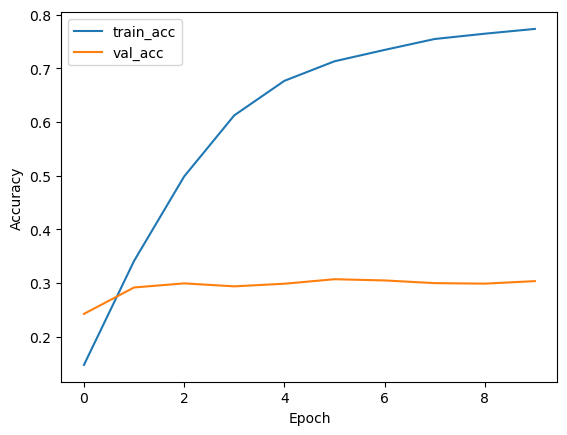

In [15]:
# Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


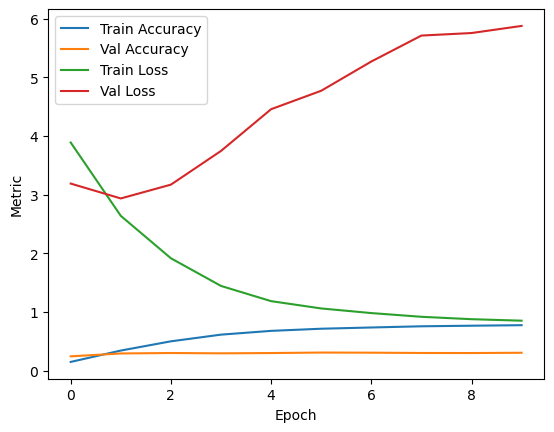

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.show()
# model.summary()
